# Trabajo Práctico integrador 3 
### Grupo 5 
* Diego Ciarrapico
* Diego Castro
* Paula Mainini
* Fanny Chuchuca
* Facundo Ponce
* Marcos Kippes 


## Importando librerias

In [2]:
#importando librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,RepeatedStratifiedKFold,cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, auc,accuracy_score,roc_auc_score
%matplotlib inline


## Definición de una función que grafique la curva roc y calcule el área bajo la curva para modelo multiclases

Al tener una variable target multiclase, y siendo condicion necesaria para la graficacion de la curva ROC y el AUC, variables target binarias se decidió realizar una función que:
* Se pueda usar en todos los modelos
* Realice una curva y calcule el auc por cada clase con la siguiente metodología: utiliza la prediccion del modelo para cada clase y modifica el y_test en 1 cuando es la clase actual y en 0 cuando es cualquier tipo de otra clase
* De esta manera se esta midiendo sensibilidad y especificidad para la clase (i) tomandola como 1 contra con el resto que será 0

In [3]:
def curva_roc_cada_clase(model, X,y_test):
    #defino un array para los nombres de las clases 
    clases = ['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
    #obtengo el predict_proba del modelo para todas las clases
    y_pred_test_proba = model.predict_proba(X)
    # en el rango del tamaño de la cantidad de columnas del predict_proba, es decir de las clases que haya encontrado
    #recordando que el predict proba me tira una columna por cada clase, en donde pone la probabilidad de esa instancia de pertenecer a esa clase
    for i in range(y_pred_test_proba.shape[1]):
        proba_clase_i = y_pred_test_proba[:, i] #me quedo con la probabilida de la clase actual en el for
        y_test_i = (y_test== i).astype(np.int32) #cambio y test, dará 1 cuando sea la clase actual y 0 cuando sea cualquier otra clase
        
        #graficando la roc curve
        fpr, tpr, thr = roc_curve(y_test_i, proba_clase_i) #desempaqueto la roc curve
        roc_auc = auc(fpr, tpr)
        print('AUC: '+str(clases[i])+' '+str(roc_auc))
        df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr = thr)) #creo el dataframe
        plt.axis([0, 1.007, 0, 1.007])
        plt.xlabel('1 - Especificidad')
        plt.ylabel('TPR / Sensitividad')
        plt.title(f'Curvas ROC 1 vs rest') #pongo el titulo para saber de que clase estoy hablando
        plt.plot(df['fpr'],df['tpr'],label=f'ROC clase {clases[i]} (area = {round(roc_auc,3)})')
        plt.legend(loc="lower right")
        
        #imprimo el area bajo la curva para cada clase
    plt.plot(np.arange(0,2, step =0.01), np.arange(0,2, step =0.01))
    plt.show()

## Leyendo el dataset

In [4]:
#leyendo y guardando el dataset target 

target_df = pd.read_csv('target.txt')
target_df = target_df.drop(['Unnamed: 0'], axis=1)
target_df.head(5)

,NObeyesdad
0,1
1,1
2,1
3,2
4,3


Dataset con las features

In [5]:
#leyendo dataset features
features_df = pd.read_csv('features_v1.txt')
features_df = features_df.drop(['Unnamed: 0'], axis=1)
features_df.head(5)

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
0,0,1,0,2,0,0,3,3,0.148936,0.320755,0.186567,0.5,0.666667,0.5,0.000000,0.5,24.386526
1,0,1,0,2,1,1,2,3,0.148936,0.132075,0.126866,1.0,0.666667,1.0,1.000000,0.0,24.238227
2,1,1,0,2,0,0,1,3,0.191489,0.660377,0.283582,0.5,0.666667,0.5,0.666667,0.5,23.765432
3,1,0,0,2,0,0,1,4,0.276596,0.660377,0.358209,1.0,0.666667,0.5,0.666667,0.0,26.851852
4,1,0,0,2,0,0,2,3,0.170213,0.622642,0.379104,0.5,0.000000,0.5,0.000000,0.0,28.342381


In [6]:
#concatenando ambos dataframe en uno solo
data = pd.concat([features_df, target_df], axis=1)
data.head()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,NObeyesdad
0,0,1,0,2,0,0,3,3,0.148936,0.320755,0.186567,0.5,0.666667,0.5,0.000000,0.5,24.386526,1
1,0,1,0,2,1,1,2,3,0.148936,0.132075,0.126866,1.0,0.666667,1.0,1.000000,0.0,24.238227,1
2,1,1,0,2,0,0,1,3,0.191489,0.660377,0.283582,0.5,0.666667,0.5,0.666667,0.5,23.765432,1
3,1,0,0,2,0,0,1,4,0.276596,0.660377,0.358209,1.0,0.666667,0.5,0.666667,0.0,26.851852,2
4,1,0,0,2,0,0,2,3,0.170213,0.622642,0.379104,0.5,0.000000,0.5,0.000000,0.0,28.342381,3


## Analizando la variable target

Segun la página de descarga del dataset, la variable target contiene 6 categorias: 
* 'Insufficient_Weight' : 0,
* 'Normal_Weight' : 1,
* 'Overweight_Level_I' : 2,
* 'Overweight_Level_II' : 3,
* 'Obesity_Type_I' : 4,
* 'Obesity_Type_II' : 5,
* 'Obesity_Type_III' : 6,

In [7]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22869 entries, 0 to 22868
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   NObeyesdad  22869 non-null  int64
dtypes: int64(1)
memory usage: 178.8 KB


In [8]:
data.NObeyesdad.value_counts()

6    4370
5    3545
1    3369
4    3261
3    2812
0    2795
2    2717
Name: NObeyesdad, dtype: int64

In [9]:
data.NObeyesdad.value_counts(normalize=True)

6    0.191088
5    0.155013
1    0.147317
4    0.142595
3    0.122961
0    0.122218
2    0.118807
Name: NObeyesdad, dtype: float64

## Analizando las features

In [10]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22869 entries, 0 to 22868
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22869 non-null  int64  
 1   family_history_with_overweight  22869 non-null  int64  
 2   FAVC                            22869 non-null  int64  
 3   CAEC                            22869 non-null  int64  
 4   SMOKE                           22869 non-null  int64  
 5   SCC                             22869 non-null  int64  
 6   CALC                            22869 non-null  int64  
 7   MTRANS                          22869 non-null  int64  
 8   Age                             22869 non-null  float64
 9   Height                          22869 non-null  float64
 10  Weight                          22869 non-null  float64
 11  FCVC                            22869 non-null  float64
 12  NCP                             

Se pueden ver los tipos de datos y que no hay nulos

In [11]:
features_df.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'Age', 'Height', 'Weight', 'FCVC', 'NCP',
       'CH2O', 'FAF', 'TUE', 'BMI'],
      dtype='object')

In [12]:
features_df.describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,0.498666,0.819450,0.911627,1.849316,0.012637,0.034238,2.227426,2.493769,0.210325,0.472410,0.363937,0.721714,0.584781,0.513721,0.328127,0.310275,30.191840
std,0.500009,0.384653,0.283843,0.450872,0.111705,0.181845,0.477871,1.160286,0.122413,0.165813,0.196748,0.266664,0.237570,0.304450,0.279822,0.301425,8.305989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.868541
25%,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,3.000000,0.127660,0.342758,0.201493,0.500000,0.666667,0.377954,0.005287,0.000000,24.092971
50%,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,3.000000,0.187562,0.471698,0.335821,0.696333,0.666667,0.500000,0.333333,0.289770,29.384757
75%,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.000000,0.255319,0.590621,0.541278,1.000000,0.666667,0.767564,0.532192,0.500000,36.878525
max,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.997991


- 'Gender' : Categórica binaria, indica el género de la persona.
- 'family_history_with_overweight' : Categórica binaria, indica si tiene familiares con historial de sobrepeso.
- 'FAVC' : Categórica binaria (Frecuencia de consumo de alimentos altos en calorías).
- 'CAEC' : Categórica (Frecuencia de consumo de comida entre comidas).
- 'SMOKE' : Categórica binaria, indica si la persona fuma.
- 'SCC' : Categórica (Consumo de alcohol).
- 'CALC' : Categórica (Actividad física actual).
- 'MTRANS' : Categórica (Método de transporte utilizado).
- 'Age' : Numérica, representa la edad de la persona.
- 'Height' : Numérica, representa la altura de la persona.
- 'Weight' : Numérica, representa el peso de la persona.
- 'FCVC' : Numérica (Frecuencia de consumo de verduras).
- 'NCP' : Numérica (Número de comidas principales al día).
- 'CH2O' : Numérica (Consumo diario de agua).
- 'FAF' : Numérica (Frecuencia de actividad física semanal).
- 'TUE' : Numérica (Tiempo de uso de dispositivos electrónicos diario).
- 'BMI' : Numérica, representa el Índice de Masa Corporal de la persona.



Por la informacion del dataset, se ve que las variables categóricas están pasadas a dummies y las variables numéricas normalizadas

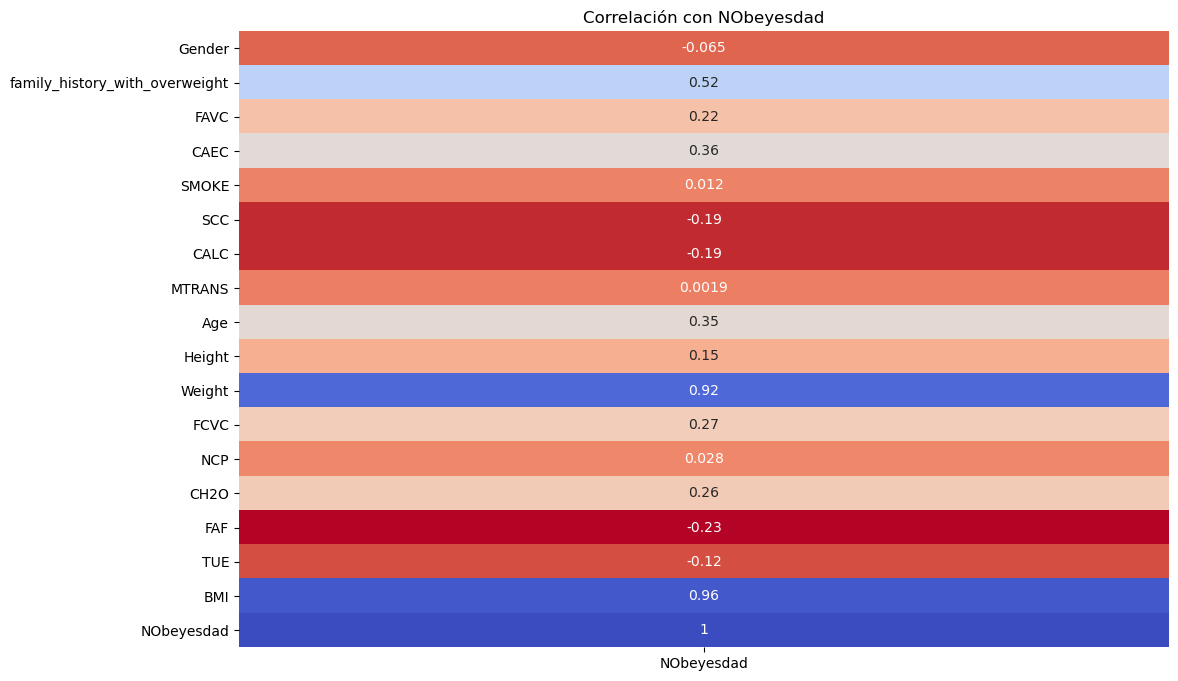

In [13]:
#graficando la correlacion de las variables con la variable target
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr()['NObeyesdad'].to_frame(), annot=True, cmap='coolwarm_r', cbar=False)
plt.title('Correlación con NObeyesdad')
plt.show()

<AxesSubplot:xlabel='NObeyesdad', ylabel='Weight'>

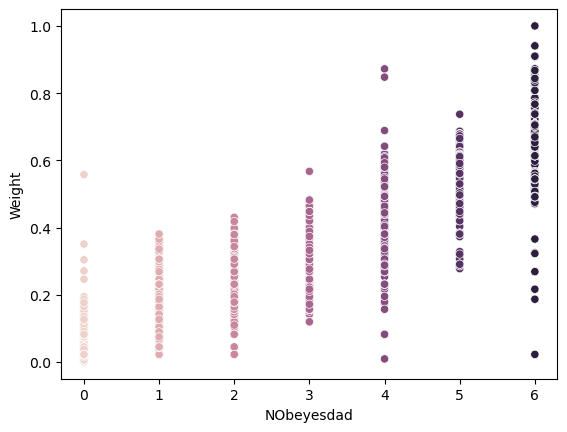

In [14]:
#graficando un scatterplot entre peso y obesidad que se tiene una correlacion alta
#se verifica que ante mayor peso mayor grado de la clasificacion de obesidad
sns.scatterplot(data=data, x='NObeyesdad', y='Weight', hue='NObeyesdad',legend=False)

<AxesSubplot:xlabel='NObeyesdad', ylabel='BMI'>

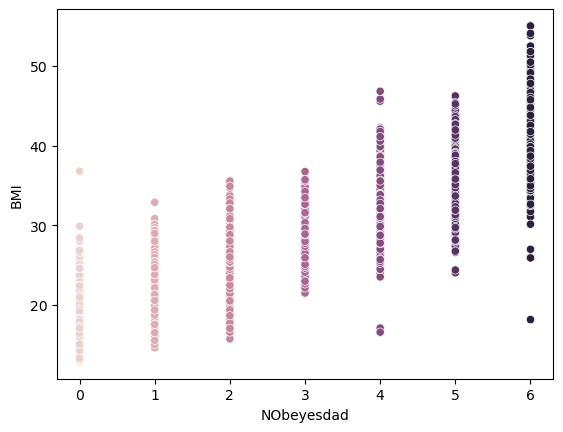

In [15]:
#graficando un scatterplot entre indice de masa corporal y obesidad que se tiene una correlacion alta
#se verifica que ante mayor BMI mayor grado de la clasificacion de obesidad
sns.scatterplot(data=data, x='NObeyesdad', y='BMI', hue='NObeyesdad',legend=False)

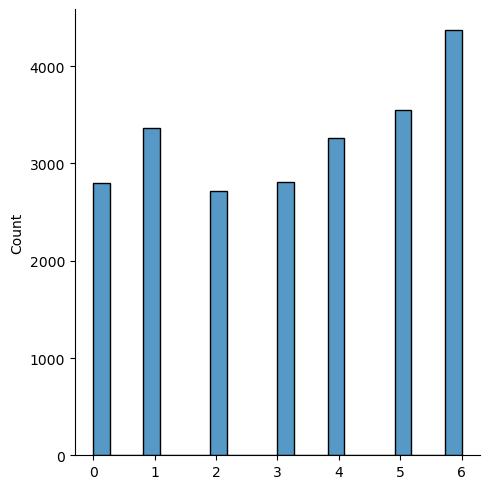

In [16]:
sns.displot(target_df,legend=False)

## Division del dataset en train y test

In [17]:
X = features_df
y = data.NObeyesdad

In [18]:
#se usa stratify para respetar la distribucion original de la variable target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17151, 17)
(5718, 17)
(17151,)
(5718,)


verificamos que las proporciones del target se hayan respetado tanto en y_train como en y_test

In [20]:
data.NObeyesdad.value_counts(normalize=True)

6    0.191088
5    0.155013
1    0.147317
4    0.142595
3    0.122961
0    0.122218
2    0.118807
Name: NObeyesdad, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

6    0.191151
5    0.155124
1    0.147254
4    0.142532
3    0.122945
0    0.122246
2    0.118748
Name: NObeyesdad, dtype: float64

In [22]:
y_train.value_counts(normalize=True)

6    0.191068
5    0.154976
1    0.147338
4    0.142616
3    0.122967
0    0.122209
2    0.118827
Name: NObeyesdad, dtype: float64

Como se menciono previamente, las features ya se encuentran normalizadas y pasadas a dummies, por lo tanto el preprocesamiento de los datos termina aquí

# K neighbors

### Cross Validation (n_neighbors)

In [23]:
def scores_knn(X, y, start,stop,step):
    
    # Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto vamos a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    
    # Lista de diccionarios - la inicializamos vacío y por fuera del for loop para ir alimentándola en cada iteración
    scores_para_df = []
    
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits=10, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    # Retornamos el DF
    return df_scores

In [24]:
# Probamos de 1 a 20 vecinos
df_scores= scores_knn(X_train, y_train, 1, 21, 1)

(0.7, 1.0)

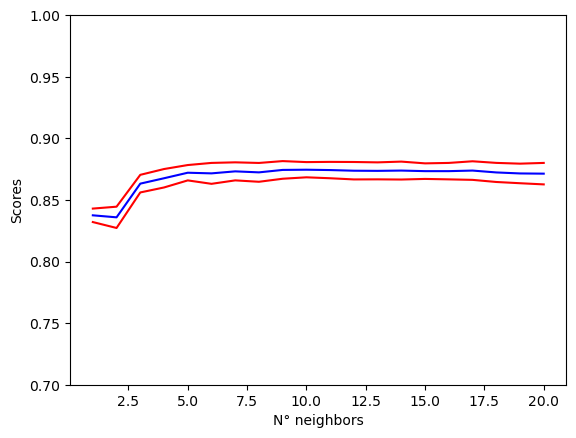

In [25]:
# Visualizamos los resultados

plt.plot(df_scores['n_neighbours'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbours'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbours'], df_scores['limite_superior'], color='r')
plt.xlabel('N° neighbors')
plt.ylabel('Scores')
plt.ylim(0.7, 1)

- Aquí podemos observar que el k óptimo es 10 con un score de 0.874526

In [26]:
# Identificamos el score máximo
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
9,0.874526,0.006176,10,0.868349,0.880702


In [27]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values[0]
best_k

10

In [28]:
# Elegimos el modelo óptimo que nos había indicado cross validation
KNN = KNeighborsClassifier(n_neighbors=best_k)

In [29]:
# Lo ajustamos sobre datos de entrenamiento
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

- Evaluando el modelo en train podemos observar que tenemos un accuracy de 89%

In [30]:
# Evaluamos qué accuracy en train
accuracy_score(y_train, KNN.predict(X_train))

0.886245699959186

- Evaluando el modelo en train podemos observar que tenemos un accuracy de 87% (86.8%).

In [31]:
# Lo utilizamos para predecir en test
y_pred_KNN = KNN.predict(X_test)

In [32]:
# Computamos el accuracy score en test
accuracy_score(y_test, y_pred_KNN)

0.8684854844351172

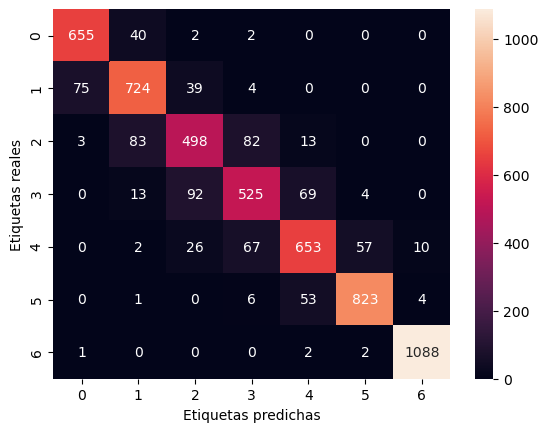

In [33]:
# Graficamos la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_KNN), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

#### Análisis de la matriz de confusión

- El accuracy general del modelo es de 0.868, es decir clasifico el 87% de casos correctamente. 
- Clase 0: Peso insuficiente: Del total de casos de esta clase, el 89% están clasificados correctamente, mientras que el 11% son falsos positivos.
- Clase 1: Peso normal. Del total de casos de esta clase, el 84% son clasificados correctamente, mientras que el 16% son falsos positivos.
- Clase 2: Sobrepeso nivel 1. Del total de casos de esta clase, el 76% son clasificados correctamente, mientras que el 24% son falsos positivos.
- Clase 3: Sobrepeso nivel 2. Del total de casos de esta clase, el 77% fueron clasificados correctamente, mientras que el 23% son falsos positivos.
- Clase 4: Obesidad tipo 1. Del total de casos de esta clase, el 83% fueron clasificados correctamente, mientras que el 17% resultaron ser falsos positivos.
- Clase 5: Obesidad tipo 2. Del total de casos de esta clase, el 93% fueron clasificados correctamente, mientras que el 7% resultaron ser falsos positivos.
- Clase 6: Obesidad tipo 3. Del total de casos de esta clase, el 99% fueron clasificados correctamente, mientras que el 1% resultaron ser falsos positivos.

El modelo está prediciendo bastante bien la clase 5 (Obesidad tipo 2) y clase 6 (Obesidad tipo3), con porcentajes que superan el 93%. Sin embargo un peor desempeño en las categorías anteriores desde la clase 0 a la clase 4. Estos resultados son obtenidos con Cross Validation con el k devuelto anteriormente.

### GridSearchCV

In [34]:
# armamos los parámetros para GridSearchCV
params_KNN = {'n_neighbors': range(1,21),     'weights' : ['uniform', 'distance'],     'p' : [1, 2, 3]}

In [35]:
# importamos e instanciamos el GridSearchCV
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [36]:
gs_KNN = GridSearchCV(estimator=KNN, param_grid=params_KNN, scoring='accuracy', cv=folds, n_jobs=-1,verbose=1)
gs_KNN.fit(X_train, y_train) # entrenamos el modelo

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=10), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 21), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [37]:
# ¿cuál fue la mejor combinación de hiperparámetros encontrada por GridSearchCV? 

print (gs_KNN.best_score_)
print (gs_KNN.best_estimator_)
gs_KNN=gs_KNN.best_estimator_

0.8837388461878259
KNeighborsClassifier(n_neighbors=12, p=1, weights='distance')


In [38]:
y_pred_test_gs_KNN = gs_KNN.predict(X_test)
y_pred_train_gs_KNN = gs_KNN.predict(X_train)

### Evaluando el modelo

In [39]:
# Computamos el accuracy score en test
print(accuracy_score(y_test, y_pred_test_gs_KNN))
accuracy_score(y_train, y_pred_train_gs_KNN)

0.8742567331234697


0.9998833887236895

In [40]:
#mostrando accuracy y metricas individuales para cada clase en test
print (classification_report(y_test, y_pred_test_gs_KNN))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       699
           1       0.83      0.87      0.85       842
           2       0.77      0.73      0.75       679
           3       0.77      0.75      0.76       703
           4       0.84      0.83      0.83       815
           5       0.94      0.94      0.94       887
           6       0.99      1.00      0.99      1093

    accuracy                           0.87      5718
   macro avg       0.86      0.86      0.86      5718
weighted avg       0.87      0.87      0.87      5718



#### Análisis del clasification report del modelo KNN con GridsearchCV

- El accuracy general del modelo es de 0.874, es decir clasifico el 87% de casos correctamente. 
- Clase 0: Peso insuficiente: Tiene una sensibilidad o recall de 93%, es decir de todos los casos positivos de esa clase (peso insuficiente), detecto el 93% de ellos. Con respecto a precision, es decir cuando se predice que el peso es insuficiente, qué tan frecuente es correcta esta prediccion, tiene un 91%.
- Clase 1: Peso normal. De todos los casos verdaderos de peso normal se detectaron el 87% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 83% de las veces.
- Clase 2: Sobrepeso nivel 1. De todos los casos verdaderos de sobrepeso (nivel 1) se detectó el 73% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 77% de las veces.
- Clase 3: Sobrepeso nivel 2. De todos los casos verdaderos de sobrepeso (nivel 2) se detectó el 75% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 77% de las veces.
- Clase 4: Obesidad tipo 1. De todos los casos verdaderos de obesidad (tipo 1) se detectaron el 83% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 84% de las veces.
- Clase 5: Obesidad tipo 2. De todos los casos verdaderos de obesidad (tipo 2) se detectaron el 94% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 94% de las veces.
- Clase 6: Obesidad tipo 3. De todos los casos verdaderos de obesidad (tipo 3) se detectaron el 100% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 99% de las veces.
- El f1-score en todos los casos es el promedio armonico de la sensibilidad y precision.

Text(0.5, 23.52222222222222, 'Etiquetas predichas')

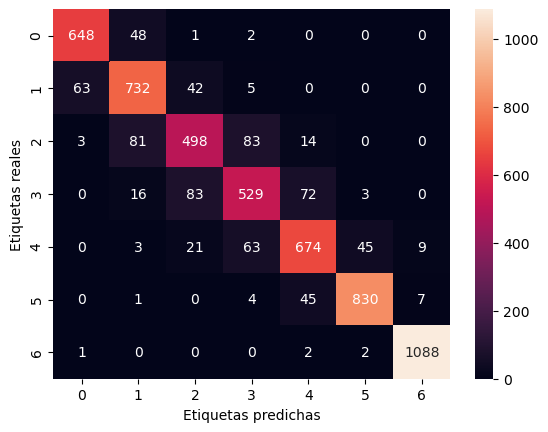

In [41]:
# Graficamos la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_test_gs_KNN), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

#### Análisis de la matriz de confusión

- Clase 0: Peso insuficiente: Del total de casos de esta clase, el 91% están clasificados correctamente, mientras que el 9% son falsos positivos.
- Clase 1: Peso normal. Del total de casos de esta clase, el 83% son clasificados correctamente, mientras que el 17% son falsos positivos.
- Clase 2: Sobrepeso nivel 1. Del total de casos de esta clases, el 77% son clasificados correctamente, mientras que el 23% son falsos positivos.
- Clase 3: Sobrepeso nivel 2. Del total de casos de esta clase, el 77% fueron clasificados correctamente, mientras que el 23% son falsos positivos.
- Clase 4: Obesidad tipo 1. Del total de casos de esta clase, el 84% fueron clasificados correctamente, mientras que el 16% resultaron ser falsos positivos.
- Clase 5: Obesidad tipo 2. Del total de casos de esta clase, el 94% fueron clasificados correctamente, mientras que el 6% resultaron ser falsos positivos.
- Clase 6: Obesidad tipo 3. Del total de casos de esta clase, el 99% fueron clasificados correctamente, mientras que el 1% resultaron ser falsos positivos.

A pesar de que en el modelo inicial se tuvo un porcentaje alto de predicción de casos correctamente en clase 5 (Obesidad tipo 2) y clase 6 (Obesidad tipo3), con GriSearchCV mejora aún más, como podemos observar en la matriz de confusión, en donde se vió un incremento en los casos correctamente clasificados y la disminución de los falsos positivos. Además se tuvo una mejora en la clase 0 (Peso insuficiente), clase 4 (Sobrepeso nivel 1) y clase 5 y 6 (Obsesidad tipo 1 y 2 respectivamente).

### Curva ROC

In [42]:
y_pred_proba_gs_KNN = gs_KNN.predict_proba(X_test)

In [43]:
display(y_pred_proba_gs_KNN.shape, y_pred_proba_gs_KNN)

(5718, 7)

array([[0.        , 0.        , 0.        , ..., 0.85282826, 0.        ,
        0.14717174],
       [0.35538532, 0.56844238, 0.07617231, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.40446509, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

AUC: Insufficient_Weight 0.9894589401476107
AUC: Normal_Weight 0.9765255534402834
AUC: Overweight_Level_I 0.9495693531543796
AUC: Overweight_Level_II 0.9588275004290115
AUC: Obesity_Type_I 0.9630216381857108
AUC: Obesity_Type_II 0.9871585170650747
AUC: Obesity_Type_III 0.9975877945649217


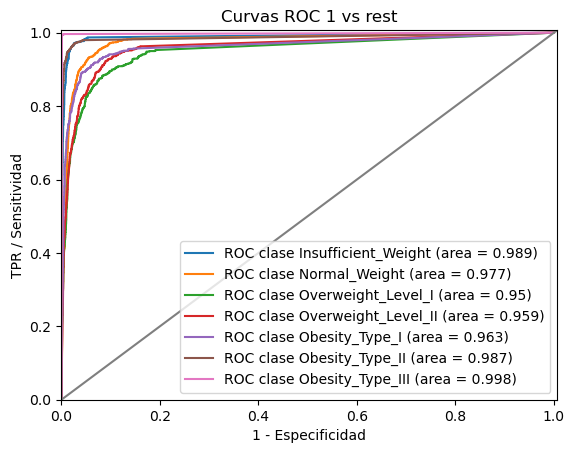

In [44]:
#calculando las curvas roc y auc para el modelo
curva_roc_cada_clase(gs_KNN, X_test,y_test)  

- Todas las Curvas ROC para cada clase muestran un valor superior a 0.95
- En las clases más extremas se obtienen curvas que rozan la curva perfecta, incluso en la clase 6 (Obesity_Type_III) se observa un AUC DE 99. En las clases intermedias esto baja siendo la clase 2 la de peor desempeño CON 0.95. 
- En general se ven muy buenos modelos.

# NAIVE BAYES

A la hora de elegir qué modelo de Naive Bayes utilizar, si el gaussiano o el multinomial, se concluye que ambos pueden servir para el presente dataset.
Se puede asumir que muchas de las features (peso, altura, actividad fisica y alimentacion) pueden tener una distribucion gaussiana igual que la obesidad. Por otra parte, no se debería descartar el uso de un predictor multinomial porque tambien se puede pensar a las features como el recuento en distintas categorias. 
Por lo tanto se realizaran ambos modelos y se evaluará cuál de los dos es el mejor

Por otra parte, se puede buscar evitar el problema de frecuencia 0  buscando un alpha adecuado (laplace smoothing para el modelo multinomial) con grid search

De estos se elegirá el que mejor ajuste para utilizar el gridsearch para mejorarlo

## Gaussiano

In [45]:
#instanciando el modelo gaussiano
GNB = GaussianNB()

GNB.fit(X_train, y_train)


GaussianNB()

In [46]:
y_pred_train_gnb = GNB.predict(X_train)
y_pred_test_gnb = GNB.predict(X_test)
y_pred_test_proba_gnb = GNB.predict_proba(X_test)

In [47]:
#mostrando accuracy y metricas individuales para cada clase en train
print(classification_report(y_train, y_pred_train_gnb ))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      2096
           1       0.85      0.64      0.73      2527
           2       0.68      0.53      0.59      2038
           3       0.60      0.66      0.63      2109
           4       0.70      0.64      0.67      2446
           5       0.80      0.95      0.87      2658
           6       0.97      1.00      0.98      3277

    accuracy                           0.79     17151
   macro avg       0.77      0.77      0.76     17151
weighted avg       0.78      0.79      0.78     17151



In [48]:
#mostrando accuracy y metricas individuales para cada clase en train
print(classification_report(y_test, y_pred_test_gnb ))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       699
           1       0.82      0.65      0.73       842
           2       0.65      0.51      0.57       679
           3       0.58      0.63      0.61       703
           4       0.72      0.67      0.69       815
           5       0.79      0.95      0.87       887
           6       0.97      0.99      0.98      1093

    accuracy                           0.78      5718
   macro avg       0.77      0.77      0.76      5718
weighted avg       0.78      0.78      0.78      5718



### Análisis del clasification report en test del modelo gaussiano:
* El accuracy general del modelo es de 0.78, es decir clasifico el 78% de casos correctamente. 
* Clase 0: Peso insuficiente: Tiene una sensibilidad o recall de 0.82, es decir de todos los casos positivos de esa clase (peso insuficiente), detecto el 82% de ellos. Con respecto a precision, es decir cuando se predice que el peso es insuficiente, qué tan frecuente es correcta esta prediccio, tiene un 96%. 
* Clase 1: Peso normal. De todos los casos verdaderos de peso normal se detectaron el 65% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 82% de las veces.
* Clase 2: Sobrepeso nivel 1. De todos los casos verdaderos de sobrepeso (nivel 1) se detectaron sólo el 51% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 65% de las veces.
* Clase 3: Sobrepeso nivel 2. De todos los casos verdaderos de sobrepeso (nivel 2)  se detectaron el 63% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 58% de las veces.
* Clase 4: Obesidad tipo 1. De todos los casos verdaderos de obesidad (tipo 1)  se detectaron el 67% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 72% de las veces.
* Clase 5: Obesidad tipo 2. De todos los casos verdaderos de obesidad (tipo 2)  se detectaron el 95% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 79% de las veces.
* Clase 6: Obesidad tipo 3. De todos los casos verdaderos de obesidad (tipo 3)  se detectaron el 99% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 97% de las veces.
* El f1 en todos los casos es el promedio armonico de la sensibilidad y precision ya explicitados.
### Conclusión:
A partir de estos datos se puede ver que la clase 6, obesidad tipo 3, es la mejor detectada por este modelo, también se observa una buena performance en obesidad tipo 2 y peso insuficiente. La clase 2, es decir sobrepeso nivel 1 es la que peor puntaje encuentra.



En la matriz de confusion se puede ver el detalle del análisis

Text(0.5, 23.52222222222222, 'Clase Predicha')

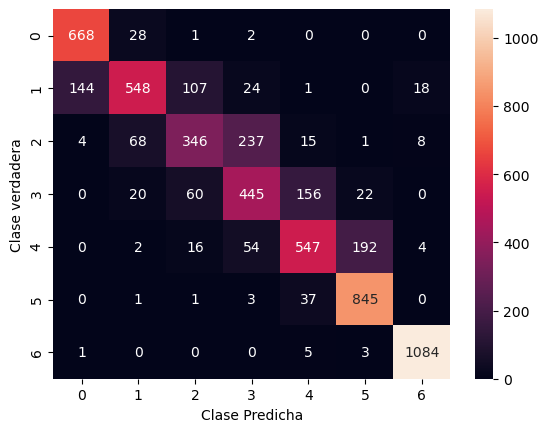

In [49]:
conf_mat = confusion_matrix(y_test, y_pred_test_gnb)
sns.heatmap(conf_mat,annot=True,fmt='.4g')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase Predicha')

En esta matriz se ve que los extremos de las clases son los menos confusos para el modelo mientras que las clases intermedias son las que mas errores tienen

### La conclusion que se obtiene es la siguiente: 
En las clases más extremas se obtienen curvas que rozan la curva perfecta, incluso en la clase 6 se observa un AUC DE 99. En las clases intermedias esto baja siendo la clase 2 la de peor desempeño.
En lineas generales se ve muy buenos modelos.

## Multinomial

En este modelo se usará grid search para obtener el parametro alpha que maximice el accuracy y se usará este modelo directamente

In [50]:
#instanciando el modelo multinomial
#para el modelo multinomial buscamos un alpha para evitar el problema de frecuencia 0 
mnb = MultinomialNB()
#seteamos los posibles parametros de alpha para realizar la busqueda con grid search 
mnb.fit(X_train, y_train)

MultinomialNB()

In [51]:
y_pred_train_mnb = mnb.predict(X_train)
y_pred_test_mnb = mnb.predict(X_test)
y_pred_test_proba_mnb = mnb.predict_proba(X_test)

In [52]:
#mostrando accuracy y metricas individuales para cada clase en train
print(classification_report(y_train, y_pred_train_mnb ))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66      2096
           1       0.47      0.69      0.56      2527
           2       0.71      0.16      0.26      2038
           3       0.37      0.13      0.19      2109
           4       0.48      0.28      0.36      2446
           5       0.62      0.90      0.73      2658
           6       0.60      1.00      0.75      3277

    accuracy                           0.58     17151
   macro avg       0.58      0.53      0.50     17151
weighted avg       0.58      0.58      0.53     17151



In [53]:
#mostrando accuracy y metricas individuales para cada clase en train
print(classification_report(y_test, y_pred_test_mnb ))

              precision    recall  f1-score   support

           0       0.79      0.56      0.66       699
           1       0.46      0.69      0.55       842
           2       0.62      0.16      0.26       679
           3       0.30      0.09      0.14       703
           4       0.48      0.27      0.34       815
           5       0.62      0.91      0.73       887
           6       0.60      0.99      0.75      1093

    accuracy                           0.57      5718
   macro avg       0.55      0.52      0.49      5718
weighted avg       0.55      0.57      0.52      5718



### Análisis del clasification report en test del modelo multinomial:
* El accuracy general del modelo es de 0.57, es decir clasifico el 57% de casos correctamente. Ya con el accuracy se puede esbozar que el rendimiento es mucho más bajo en el modelo multinomial que en el gaussiano 
* Clase 0: Peso insuficiente: Tiene una sensibilidad o recall de 0.56, es decir de todos los casos positivos de esa clase (peso insuficiente), detecto el 56% de ellos. Con respecto a precision, es decir cuando se predice que el peso es insuficiente, qué tan frecuente es correcta esta prediccio, tiene un 79%. 
* Clase 1: Peso normal. De todos los casos verdaderos de peso normal se detectaron el 69% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 46% de las veces.
* Clase 2: Sobrepeso nivel 1. De todos los casos verdaderos de sobrepeso (nivel 1) se detectaron sólo el 16% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 62% de las veces.
* Clase 3: Sobrepeso nivel 2. De todos los casos verdaderos de sobrepeso (nivel 2)  se detectaron el 9% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 30% de las veces.
* Clase 4: Obesidad tipo 1. De todos los casos verdaderos de obesidad (tipo 1)  se detectaron el 27% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 48% de las veces.
* Clase 5: Obesidad tipo 2. De todos los casos verdaderos de obesidad (tipo 2)  se detectaron el 91% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 62% de las veces.
* Clase 6: Obesidad tipo 3. De todos los casos verdaderos de obesidad (tipo 3)  se detectaron el 99% de las veces, y de los casos en los que se predijo, la prediccion fue correcta un 60% de las veces.
* El f1 en todos los casos es el promedio armonico de la sensibilidad y precision ya explicitados.
### Conclusión:
A partir de estos datos se puede ver que la performance es peor no solo globalmente sino tambien en cada clase. Todas las metricas de las clases empeoraron significativamente con respecto al modelo gaussiano

Text(0.5, 23.52222222222222, 'Clase Predicha')

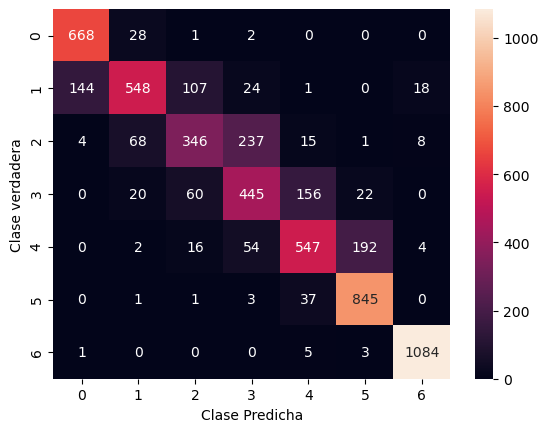

In [54]:
conf_mat = confusion_matrix(y_test, y_pred_test_gnb)
sns.heatmap(conf_mat,annot=True,fmt='.4g')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase Predicha')

La matriz de confusion tambien arroja un peor resultado

## Utlizacion de Gridsearch

Como el modelo Gaussiano fue el que mejor ajusto los datos se procederá a optimizar este modelo.

In [55]:
GNB.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [56]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [57]:

params_NB = {'var_smoothing': np.logspace(0,-11, num=50)}

gs_NB = GridSearchCV(estimator=GNB, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gs_NB.fit(X_test, y_test)

Fitting 15 folds for each of 50 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    7.2s finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 5.96362332e-01, 3.55648031e-01, 2.12095089e-01,
       1.26485522e-01, 7.54312006e-02, 4.49843267e-02, 2.68269580e-02,
       1.59985872e-02, 9.54095476e-03, 5.68986603e-03, 3.39322177e-03,
       2.02358965e-03, 1.20679264e-03, 7...
       5.17947468e-07, 3.08884360e-07, 1.84206997e-07, 1.09854114e-07,
       6.55128557e-08, 3.90693994e-08, 2.32995181e-08, 1.38949549e-08,
       8.28642773e-09, 4.94171336e-09, 2.94705170e-09, 1.75751062e-09,
       1.04811313e-09, 6.25055193e-10, 3.72759372e-10, 2.22299648e-10,
       1.32571137e-10, 7.90604321e-11, 4.71486636e-11, 2.81176870e-11,
       1.67683294e-11, 1.00000000e-11])},
             scoring='accuracy', verbose=1)

In [58]:
gs_NB.best_params_

{'var_smoothing': 0.0020235896477251575}

In [59]:
gs_NB.best_score_

0.8341485723375487

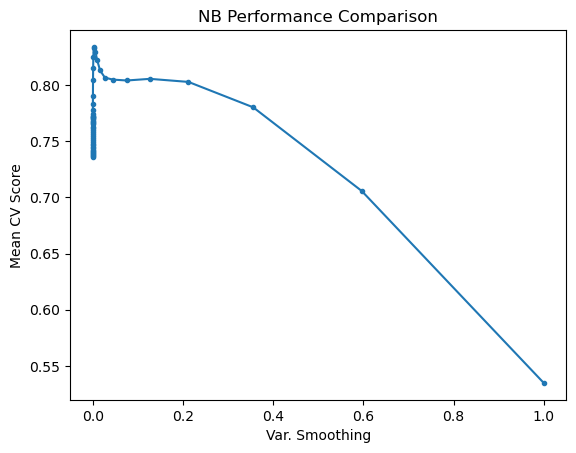

In [60]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [61]:
# ¿cuál fue la mejor combinación de hiperparámetros encontrada por GridSearchCV? 

print (gs_NB.best_score_)
print (gs_NB.best_estimator_)
gs_NB=gs_NB.best_estimator_

0.8341485723375487
GaussianNB(var_smoothing=0.0020235896477251575)


In [62]:

Y_pred_test_gs_NB = gs_NB.predict(X_test)
Y_pred_train_gs_NB = gs_NB.predict(X_train)


In [63]:
round(accuracy_score(y_train, Y_pred_train_gs_NB), 3)

0.834

In [64]:
round(accuracy_score(y_test, Y_pred_test_gs_NB), 3)

0.835

In [65]:
print(classification_report(y_test, Y_pred_test_gs_NB ))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       699
           1       0.87      0.75      0.80       842
           2       0.71      0.74      0.73       679
           3       0.73      0.72      0.72       703
           4       0.79      0.68      0.73       815
           5       0.83      0.94      0.88       887
           6       0.97      1.00      0.98      1093

    accuracy                           0.84      5718
   macro avg       0.82      0.82      0.82      5718
weighted avg       0.83      0.84      0.83      5718



### Conclusión del clasification report en test del modelo gaussiano:
Se puede ver que el gridsearch mejoró notablemente el accuracy del modelo con respecto al modelo gaussiano original principalmente en las clases de sobrepeso y obesidad tipo 1 donde el modelo original teniía la peor desempeño.

In [66]:
conf_mat = confusion_matrix(y_test, Y_pred_test_gs_NB)

Text(0.5, 23.52222222222222, 'Clase Predicha')

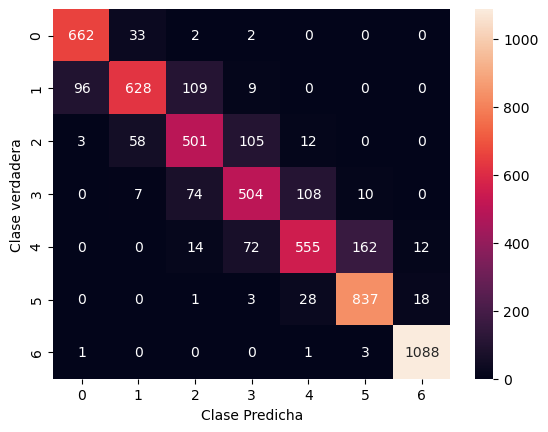

In [67]:
sns.heatmap(conf_mat,annot=True,fmt='.4g')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase Predicha')

La matriz de confusión también muestra mejores números en la diagonal central, confirmando la conclusión anterior.

AUC: Insufficient_Weight 0.9927559964552441
AUC: Normal_Weight 0.9779529967907187
AUC: Overweight_Level_I 0.9597864199742744
AUC: Overweight_Level_II 0.9585082590067636
AUC: Obesity_Type_I 0.9571192796697652
AUC: Obesity_Type_II 0.9900436326178849
AUC: Obesity_Type_III 0.9986322791226726


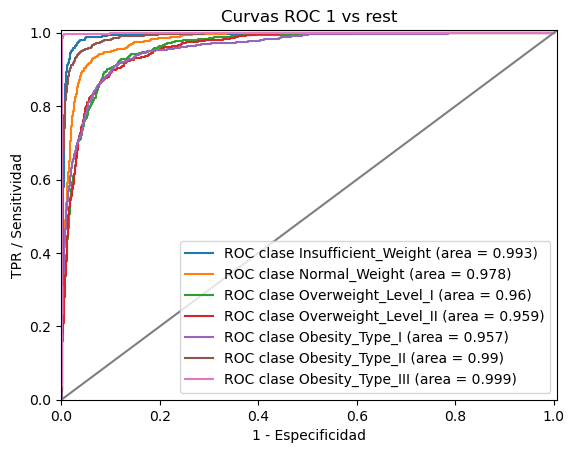

In [68]:
#calculando las curvas roc y auc para el modelo gaussiano
curva_roc_cada_clase(gs_NB, X_test,y_test)  

Todas las Curvas ROC para cada clase muestran un valor superior a 0.95

# Regresion logísitica

In [69]:
# Normalizar las características numéricas para facilitar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión logística
# Se le baja la tolerancia para acelerar la convergencia y no afecta al resultado del modelo
LogReg = LogisticRegression(max_iter = 1000,tol=1e-3)   

# Entrenar el modelo
LogReg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, tol=0.001)

In [70]:
y_pred_train_LogReg = LogReg.predict(X_train_scaled)
print(accuracy_score(y_train, y_pred_train_LogReg))

0.8696285930849513


              precision    recall  f1-score   support

           0       0.89      0.94      0.92       699
           1       0.85      0.83      0.84       842
           2       0.73      0.73      0.73       679
           3       0.74      0.69      0.72       703
           4       0.84      0.85      0.84       815
           5       0.94      0.96      0.95       887
           6       0.99      1.00      0.99      1093

    accuracy                           0.87      5718
   macro avg       0.86      0.86      0.86      5718
weighted avg       0.87      0.87      0.87      5718



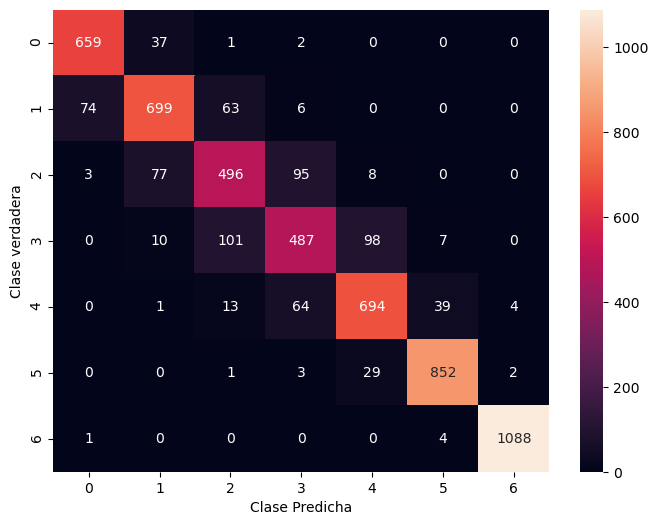

In [71]:

# Predecir en el conjunto de prueba
y_pred_test_LogReg = LogReg.predict(X_test_scaled)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test_LogReg)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix,annot=True,fmt='.4g')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase Predicha')
#Elaboramos el Reporte de Clasificacion
class_report = classification_report(y_test, y_pred_test_LogReg)
print(class_report)




### Análisis del clasification report en test del modelo de regresion logistica: 
### Precision
Clase 0: 0.89 (89% de las instancias predichas como clase 0 son realmente de clase 0).
Clase 1: 0.87 (87% de las instancias predichas como clase 1 son realmente de clase 1).
Clase 2: 0.74 (74% de las instancias predichas como clase 2 son realmente de clase 2).
Clase 3: 0.76 (76% de las instancias predichas como clase 3 son realmente de clase 3).
Clase 4: 0.84 (84% de las instancias predichas como clase 4 son realmente de clase 4).
Clase 5: 0.93 (93% de las instancias predichas como clase 5 son realmente de clase 5).
Clase 6: 0.99 (99% de las instancias predichas como clase 6 son realmente de clase 6).

### Recall

Clase 0: 0.92 (El modelo identificó correctamente el 92% de todas las instancias de clase 0).
Clase 1: 0.82 (El modelo identificó correctamente el 82% de todas las instancias de clase 1).
Clase 2: 0.74 (El modelo identificó correctamente el 74% de todas las instancias de clase 2).
Clase 3: 0.75 (El modelo identificó correctamente el 75% de todas las instancias de clase 3).
Clase 4: 0.84 (El modelo identificó correctamente el 84% de todas las instancias de clase 4).
Clase 5: 0.96 (El modelo identificó correctamente el 96% de todas las instancias de clase 5).
Clase 6: 1.00 (El modelo identificó correctamente el 100% de todas las instancias de clase 6).

In [72]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100,1000,2000,5000]  # Regularización
}


# Crear el objeto GridSearchCV
gs_LogReg = GridSearchCV(estimator=LogReg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1,n_jobs=-1)

# Entrenar el modelo utilizando GridSearchCV
gs_LogReg.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros y la mejor precisión
best_params = gs_LogReg.best_params_
best_accuracy = gs_LogReg.best_score_

print("Mejores parámetros encontrados:", best_params)
print("Mejor precisión encontrada:", best_accuracy)
y_pred_train_gs_LogReg = gs_LogReg.predict(X_train_scaled)
print(accuracy_score(y_train, y_pred_train_gs_LogReg))
y_pred_test_gs_LogReg = gs_LogReg.predict(X_test_scaled)

# Obtener el reporte de clasificación del modelo obtenido de Grid Search
report_gs_LogReg = classification_report(y_test, y_pred_test_gs_LogReg)

# Imprimir el reporte de clasificación
print("Reporte de clasificación del modelo obtenido de Grid Search:")
print(report_gs_LogReg)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Mejores parámetros encontrados: {'C': 10}
Mejor precisión encontrada: 0.8685788552836298
0.870678094571745
Reporte de clasificación del modelo obtenido de Grid Search:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       699
           1       0.86      0.83      0.84       842
           2       0.74      0.74      0.74       679
           3       0.74      0.70      0.72       703
           4       0.83      0.85      0.84       815
           5       0.94      0.96      0.95       887
           6       1.00      0.99      0.99      1093

    accuracy                           0.87      5718
   macro avg       0.86      0.86      0.86      5718
weighted avg       0.87      0.87      0.87      5718



AUC: Insufficient_Weight 0.993409592903191
AUC: Normal_Weight 0.9802795796562347
AUC: Overweight_Level_I 0.9620380764937757
AUC: Overweight_Level_II 0.9625172845616778
AUC: Obesity_Type_I 0.9729125400875137
AUC: Obesity_Type_II 0.9937000259270677
AUC: Obesity_Type_III 0.9990730199549962


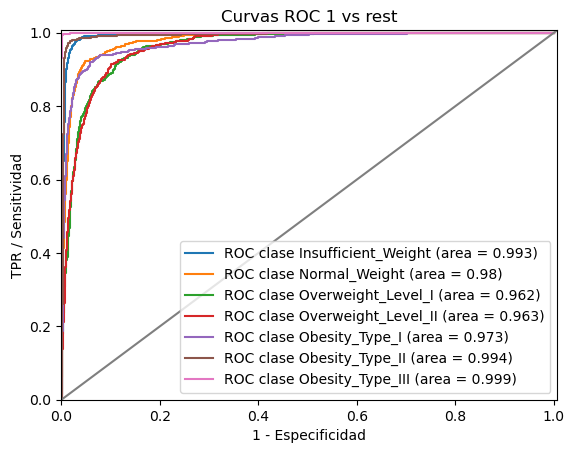

In [73]:
curva_roc_cada_clase(gs_LogReg, X_test_scaled,y_test) 

# BONUS TRACK  

In [74]:

import scipy.stats

arrays=[y_pred_test_gs_LogReg,Y_pred_test_gs_NB,y_pred_test_gs_KNN]

y_pred_test_ensemble = (scipy.stats.mode(np.stack(arrays), axis=0)).mode[0]

print('Regresion logistica--> precision en test: ',accuracy_score(y_test, y_pred_test_gs_LogReg))
print('Naive Bayes Gaussiano--> precision en test: ',accuracy_score(y_test, Y_pred_test_gs_NB))
print('K nearest neighbors--> precision en test: ',accuracy_score(y_test, y_pred_test_gs_KNN))
print('Ensamble precision--> en test: ',accuracy_score(y_test, y_pred_test_ensemble))

Regresion logistica--> precision en test:  0.8716334382651276
Naive Bayes Gaussiano--> precision en test:  0.835082196572228
K nearest neighbors--> precision en test:  0.8742567331234697
Ensamble precision--> en test:  0.8746065057712487


In [76]:
import statistics
y_pred_test_ensemble2=np.zeros(len(y_pred_test_gs_LogReg))
for i in range(len(y_pred_test_gs_LogReg)):
    array_aux=np.array([y_pred_test_gs_LogReg[i],Y_pred_test_gs_NB[i],y_pred_test_gs_KNN[i]])
    y_pred_test_ensemble2[i]=int(statistics.mode(array_aux))
    if (sum(y_pred_test_ensemble2[i]==array_aux)==1):
        y_pred_test_ensemble2[i]=np.mean(array_aux).round(0) # si son todos votos distintos toma el promedio
y_pred_test_ensemble2.shape
print('Regresion logistica--> precision en test: ',accuracy_score(y_test, y_pred_test_gs_LogReg))
print('Naive Bayes Gaussiano--> precision en test: ',accuracy_score(y_test, Y_pred_test_gs_NB))
print('K nearest neighbors--> precision en test: ',accuracy_score(y_test, y_pred_test_gs_KNN))
print('Ensamble precision--> en test: ',accuracy_score(y_test, y_pred_test_ensemble2))

Regresion logistica--> precision en test:  0.8716334382651276
Naive Bayes Gaussiano--> precision en test:  0.835082196572228
K nearest neighbors--> precision en test:  0.8742567331234697
Ensamble precision--> en test:  0.8747813920951382


La diferencia entre ambos métodos es que scipy toma el ultimo valor del array y que el metodo programado toma el primero.
Ambos métodos de ensamble tienen mejor comportamiento que los modelos base